# Cloud Computing Workflow

This example relies on model output that has already been computed and made available over the internet.
It accesses model output via the `AWS.jl` and `Zarr.jl` packages as the starting point for further modeling / computation.
Workflow summary:

- Access climate model output in cloud storage
- Choose model (`institution_id`, `source_id`, `variable_id`)
- Compute, save, and plot (_1._ global mean over time; _2._ time mean global map)

In [1]:
using ClimateModels, Plots, Statistics, TOML, CSV, DataFrames, NetCDF

## Model Configuration

Here we select that we want to access temperature (`tas`) from a model run by `IPSL` as part of [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) (Coupled Model Intercomparison Project Phase 6).

In [2]:
parameters=Dict("institution_id" => "IPSL", "source_id" => "IPSL-CM6A-LR", "variable_id" => "tas")

function GlobalAverage(x)

    #main computation = model run = access cloud storage + compute averages

    (mm,gm,meta)=cmip(x.inputs["institution_id"],x.inputs["source_id"],x.inputs["variable_id"])

    #save results to files

    fil=joinpath(x.folder,string(x.ID),"GlobalAverages.csv")
    df = DataFrame(time = gm["t"], tas = gm["y"])
    CSV.write(fil, df)

    fil=joinpath(x.folder,string(x.ID),"Details.toml")
    open(fil, "w") do io
        TOML.print(io, meta)
    end

    filename = joinpath(x.folder,string(x.ID),"MeanMaps.nc")
    varname  = x.inputs["variable_id"]
    (ni,nj)=size(mm["m"])
    nccreate(filename, "tas", "lon", collect(Float32.(mm["lon"][:])), "lat", collect(Float32.(mm["lat"][:])), atts=meta)
    ncwrite(Float32.(mm["m"]), filename, varname)

    return x
end

MC=ModelConfig(model="GlobalAverage",configuration=GlobalAverage,inputs=parameters)

  ID            = 60019133-e506-4246-9431-fe1db1373574
  model         = GlobalAverage
  configuration = GlobalAverage
  folder        = /tmp
  log subfolder = 60019133-e506-4246-9431-fe1db1373574/log


## Setup and Launch

_Note: this step may take most time, since `launch` is where data is accessed over the internet, and computation takes place.

In [3]:
setup(MC)
launch(MC)

## Read Output Files

The `GlobalAverage` function, called via `launch`, should now have generated the following output:

- Global averages in a `CSV` file
- Meta-data in a `TOML` file
- Maps + meta-data in a `NetCDF` file

In [4]:
fil=joinpath(MC.folder,string(MC.ID),"MeanMaps.nc")
lon = NetCDF.open(fil, "lon")
lat = NetCDF.open(fil, "lat")
tas = NetCDF.open(fil, "tas")

Disk Array with size 144 x 143


In [5]:
fil=joinpath(MC.folder,string(MC.ID),"Details.toml")
meta=TOML.parsefile(fil)

Dict{String, Any} with 5 entries:
  "source_id"      => "IPSL-CM6A-LR"
  "units"          => "K"
  "long_name"      => "Near-Surface Air Temperature"
  "institution_id" => "IPSL"
  "variable_id"    => "tas"

In [6]:
fil=joinpath(MC.folder,string(MC.ID),"GlobalAverages.csv")
GA=CSV.read(fil,DataFrame)
show(GA,truncate=8)

1980×2 DataFrame
  Row │ time       tas
      │ DateTime…  Float64
──────┼────────────────────
    1 │ 1850-01-…  283.762
    2 │ 1850-02-…  284.126
    3 │ 1850-03-…  284.995
    4 │ 1850-04-…  285.989
    5 │ 1850-05-…  286.785
    6 │ 1850-06-…  287.528
    7 │ 1850-07-…  288.115
    8 │ 1850-08-…  288.155
  ⋮   │     ⋮         ⋮
 1974 │ 2014-06-…  288.709
 1975 │ 2014-07-…  289.282
 1976 │ 2014-08-…  289.349
 1977 │ 2014-09-…  288.688
 1978 │ 2014-10-…  287.646
 1979 │ 2014-11-…  286.56
 1980 │ 2014-12-…  285.529
          1965 rows omitted

## Plot Results

Plots below are based on results from the output file(s) shown above.

#### 1. Time Mean Seasonal Cycle

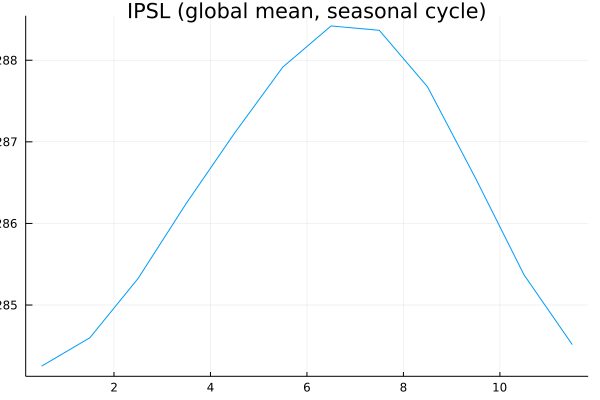

In [7]:
nm=meta["long_name"]*" in "*meta["units"]

ny=Int(length(GA.time)/12)
y=fill(0.0,(ny,12))
[y[:,i].=GA.tas[i:12:end] for i in 1:12]

s=plot([0.5:1:11.5],vec(mean(y,dims=1)), xlabel="month",ylabel=nm,
leg = false, title=meta["institution_id"]*" (global mean, seasonal cycle)",frmt=:png)

#### 2. Month By Month Time Series

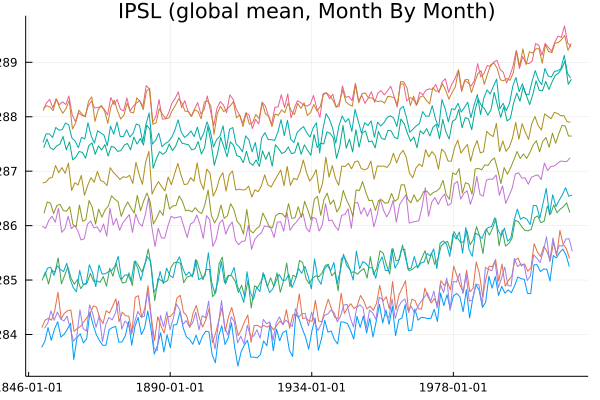

In [8]:
p=plot(GA.time[1:12:end],GA.tas[1:12:end],xlabel="time",ylabel=nm,
title=meta["institution_id"]*" (global mean, Month By Month)",frmt=:png)
[plot!(GA.time[i:12:end],GA.tas[i:12:end], leg = false) for i in 2:12];
p

#### 3. Time Mean Global Map

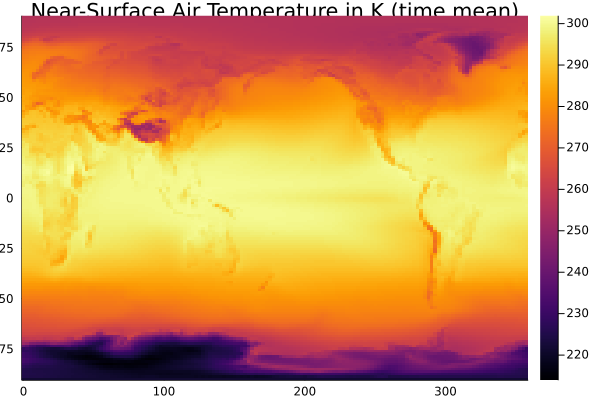

In [9]:
m=heatmap(lon[:], lat[:], permutedims(tas[:,:]), title=nm*" (time mean)")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*